# Build a semantic search engine

This tutorial will familiarize you with LangChain's document loader, embedding, and vector store abstractions. These abstractions are designed to support retrieval of data-- from (vector) databases and other sources-- for integration with LLM workflows. They are important for applications that fetch data to be reasoned over as part of model inference, as in the case of retrieval-augmented generation, or RAG (see our RAG tutorial here).

Here we will build a search engine over a PDF document. This will allow us to retrieve passages in the PDF that are similar to an input query.

## Prerequisites

You will need to provision the following Azure resources:
* Azure OpenAI with two models: GPT-4o and Embedding model.
* Azure AI Search.
You can run the terraform template from folder `../400_azure_ai_foundry` to create all of these resources by simply running the following commands.

```sh
terraform init
terraform plan -out tfplan
terraform apply tfplan
```

This tutorial requires the langchain-community and pypdf packages.

In [25]:
%pip install langchain-community pypdf --quiet

Note: you may need to restart the kernel to use updated packages.


## Documents and Document Loaders

LangChain implements a Document abstraction, which is intended to represent a unit of text and associated metadata. It has three attributes:

page_content: a string representing the content;
metadata: a dict containing arbitrary metadata;
id: (optional) a string identifier for the document.
The metadata attribute can capture information about the source of the document, its relationship to other documents, and other information. Note that an individual Document object often represents a chunk of a larger document.

We can generate sample documents when desired.

In [26]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

## Loading documents

Let's load a PDF into a sequence of Document objects. There is a sample PDF in the LangChain repo here -- a 10-k filing for Nike from 2023. We can consult the LangChain documentation for available PDF document loaders. Let's select PyPDFLoader, which is fairly lightweight.

In [27]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "./example_data/azure-for-architects.pdf" #nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

701


PyPDFLoader loads one Document object per PDF page. For each, we can easily access:

* The string content of the page;
* Metadata containing the file name and page number.

In [28]:
print(f"{docs[1].page_content[:200]}\n")
print(docs[1].metadata)

Ritesh Modi, Jack Lee, and Rithin Skaria
Create secure, scalable, high-availability 
applications on the cloud
Azure for Architects
Third Edition

{'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 'subject': 'Create secure, scalable, high-availability applications on the cloud', 'title': 'Azure for Architects, Third Edition', 'trapped': '/False', 'source': './example_data/azure-for-architects.pdf', 'total_pages': 701, 'page': 1, 'page_label': 'a'}


## Splitting

For both information retrieval and downstream question-answering purposes, a page may be too coarse a representation. Our goal in the end will be to retrieve `Document` objects that answer an input query, and further splitting our PDF will help ensure that the meanings of relevant portions of the document are not "washed out" by surrounding text.

We can use text splitters for this purpose. Here we will use a simple text splitter that partitions based on characters. We will split our documents into chunks of 1000 characters with 200 characters of overlap between chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it. We use the RecursiveCharacterTextSplitter, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

We set `add_start_index=True` so that the character index where each split Document starts within the initial Document is preserved as metadata attribute “start_index”.

In [29]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

print("Number of splits: ", len(all_splits))

Number of splits:  1473


View a sample split or chunk.

In [30]:
# print a sample chunk
print(all_splits[309])
print("---------------")
print(all_splits[310])

page_content='sender, stored in durable storage, and finally consumed by recipients.
The top architectural concerns addressed by messaging patterns are as follows:
• Durability: Messages are stored in durable storage, and applications can read 
them after they are received in case of a failover.
• Reliability: Messages help implement reliability as they are persisted on disk and 
never lost.
• Availability of messages: The messages are available for consumption by 
applications after the restoration of connectivity and before downtime.
Azure provides Service Bus queues and topics to implement messaging patterns within 
applications. Azure Queue storage can also be used for the same purpose. 
Choosing between Azure Service Bus queues and Queue storage is about deciding on 
how long the message should be stored, the size of the message, latency, and cost. 
Azure Service Bus provides support for 256 KB messages, while Queue storage provides' metadata={'producer': 'Adobe PDF Library 15.0',

## Embeddings

Vector search is a common way to store and search over unstructured data (such as unstructured text). The idea is to store numeric vectors that are associated with the text. Given a query, we can embed it as a vector of the same dimension and use vector similarity metrics (such as cosine similarity) to identify related text.

LangChain supports embeddings from dozens of providers. These models specify how text should be converted into a numeric vector. 

In [31]:
%pip install -qU langchain-openai
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

if os.path.exists(".env"):
    load_dotenv(override=True)


embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_deployment=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
    openai_api_version=os.environ["AZURE_OPENAI_EMBEDDING_API_VERSION"],
)

In [33]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"


Generated vectors of length 3072

[0.010515968315303326, -0.01905210129916668, -0.017833741381764412, 0.022737640887498856, 0.008901641704142094, -0.006392581854015589, -0.011467811651527882, 0.024169212207198143, -0.0178185123950243, 0.02282901667058468]


Armed with a model for generating text embeddings, we can next store them in a special data structure that supports efficient similarity search.

## Vector stores

LangChain VectorStore objects contain methods for adding text and `Document` objects to the store, and querying them using various similarity metrics. They are often initialized with embedding models, which determine how text data is translated to numeric vectors.

LangChain includes a suite of integrations with different vector store technologies. Some vector stores are hosted by a provider (e.g., various cloud providers) and require specific credentials to use; some (such as Postgres) run in separate infrastructure that can be run locally or via a third-party; others can run in-memory for lightweight workloads.

In [34]:
%pip install --upgrade --quiet  azure-search-documents
%pip install --upgrade --quiet  azure-identity

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain_openai import AzureOpenAIEmbeddings, AzureOpenAIEmbeddings

embeddings: AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    azure_deployment=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
    openai_api_version=os.environ["AZURE_OPENAI_EMBEDDING_API_VERSION"],
    azure_endpoint=os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"],
    api_key=os.environ["AZURE_SEARCH_SERVICE_ADMIN_KEY"],
)

## Create vector store instance

Create instance of the AzureSearch class using the embeddings from above.

In [50]:
from langchain_community.vectorstores.azuresearch import AzureSearch

# Specify additional properties for the Azure client such as the following https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/core/azure-core/README.md#configurations
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"],
    azure_search_key=os.environ["AZURE_SEARCH_SERVICE_ADMIN_KEY"],
    index_name=os.environ["AZURE_SEARCH_SERVICE_INDEX"],
    embedding_function=embeddings.embed_query,
    # Configure max retries for the Azure client
    additional_search_client_options={"retry_total": 3},
    relevance_score_fn="cosine",
)

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net/indexes('langchain-vector-demo')?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=minimal'
    'x-ms-client-request-id': '37393f1f-f392-11ef-8810-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
No body was attached to the request
INFO: Response status: 404
Response headers:
    'Cache-Control': 'no-cache,no-store'
    'Pragma': 'no-cache'
    'Content-Length': '136'
    'Content-Type': 'application/json; charset=utf-8'
    'Content-Language': 'REDACTED'
    'Expires': '-1'
    'Server': 'Microsoft-IIS/10.0'
    'request-id': '37393f1f-f392-11ef-8810-efa928428551'
    'elapsed-ti

## Insert text and embeddings into vector store

This step loads, chunks, and vectorizes the sample document, and then indexes the content into a search index on Azure AI Search.

In [51]:
vector_store.add_documents(documents=all_splits[:30])

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deploym

['ZjZkYmFlZTMtMGRhNS00NzBlLTlmNjQtMjQwZjE5ZjZiNmU2',
 'YmM3MzIxN2MtYWRmNy00Y2QxLWE0MzEtZTgzNmRiZThiZTBl',
 'MDlkOGY0YzktODU1Ni00YjVhLTkxNWMtNjliOWU4MjI5YzQ5',
 'NmUxNjRkNDUtY2FlMi00NGFhLThmM2QtMjUxODY5ZjY4Mzhl',
 'ZDY1OTUwNjYtNjg3My00ZDkwLTk1ZDgtYmYyN2JhMDM1ODM4',
 'N2RhMzkwMzEtOGRhNi00MGJhLTkyODktNTI1MjAxNWI4OGMz',
 'MjVmOGQ5YjAtNjQ5Yi00NjFkLThmMTUtODY0MmZmNGYwN2Ew',
 'MmU0NmQ3M2QtYzYyOS00MjZhLThiYmItZDMxZjFjN2Q3YmE2',
 'NDdmMDgzYWMtMjhlOS00ZDUyLWJmZTQtYjdhMTE2YzllMzBi',
 'OWJhMDg0MzktMGY3YS00ZWQ1LThiYjctNTRjNzE0Y2VmNWYy',
 'YjNkNmYyMTAtYjU1ZC00YTQzLWE1MDEtZjI2YjcwZTdjZmZi',
 'MzU1ZGMwYmQtZDI4Mi00NmYyLWIzOGQtMWE0NmI0ZWY2YWI3',
 'ZTc4ODg3OGMtMmI5NS00YTBjLWFiN2EtZTNhNWNiMTA3Njlj',
 'MGQxZTJjMjYtMWZkNi00MGU2LThkODAtMWM3M2E5YjM1OTQw',
 'NGIwMWUzN2QtMTM3Yi00OTc0LWFjODktMzJjMDA1NGRkNmRl',
 'ODkyMWVmZTUtMTMxOS00MWVjLWE0YjItYzg3YTNmMWFiNmZj',
 'MzMwNDNhMDEtMGEzMy00NzZiLWFjZTktODkyODdlODdlZDYw',
 'ZTc4YWQ3MmUtYzVlOC00YmY0LTk2MDMtODlkMzFlMjU4YTdi',
 'MTkwZWNlOGYtNmZjMC00ZTRlLWE0YTctMjk1MWQzYzQz

Once we've instantiated a VectorStore that contains documents, we can query it. VectorStore includes methods for querying:

* Synchronously and asynchronously;
* By string query and by vector;
* With and without returning similarity scores;
* By similarity and maximum marginal relevance (to balance similarity with query to diversity in retrieved results).

## Perform a vector similarity search

Execute a pure vector similarity search using the `similarity_search()` method.

In [52]:
# Perform a similarity search
docs = vector_store.similarity_search(
    query="Who are the authors of the book Azure for Architects",
    k=3,
    search_type="similarity",
)
print(docs[0].page_content)

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net//indexes('langchain-vector-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '68917'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '685ef788-f392-11ef-9981-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
A body is sent with the request
INFO: Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Server': 'Microsoft-IIS/10.

Ritesh Modi, Jack Lee, and Rithin Skaria
Create secure, scalable, high-availability 
applications on the cloud
Azure for Architects
Third Edition


## Perform a vector similarity search with relevance scores

Execute a pure vector similarity search using the `similarity_search_with_relevance_scores()` method. Queries that don't meet the threshold requirements are exluded.

In [58]:
from pprint import pprint

docs_and_scores = vector_store.similarity_search_with_relevance_scores(
    query="Who are the authors of the book Azure for Architects",
    k=4,
    score_threshold=0.70,
)

pprint(docs_and_scores)

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net//indexes('langchain-vector-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '68881'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '30ef14cf-f393-11ef-b7dc-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
A body is sent with the request
INFO: Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Server': 'Microsoft-IIS/10.

[(Document(metadata={'id': 'ZjZkYmFlZTMtMGRhNS00NzBlLTlmNjQtMjQwZjE5ZjZiNmU2', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 'subject': 'Create secure, scalable, high-availability applications on the cloud', 'title': 'Azure for Architects, Third Edition', 'trapped': '/False', 'source': './example_data/azure-for-architects.pdf', 'total_pages': 701, 'page': 1, 'page_label': 'a', 'start_index': 0}, page_content='Ritesh Modi, Jack Lee, and Rithin Skaria\nCreate secure, scalable, high-availability \napplications on the cloud\nAzure for Architects\nThird Edition'),
  0.77486813),
 (Document(metadata={'id': 'YmM3MzIxN2MtYWRmNy00Y2QxLWE0MzEtZTgzNmRiZThiZTBl', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-17T14:21:14+05:30', 's

## Perform a hybrid search

Execute hybrid search using the search_type or hybrid_search() method. Vector and nonvector text fields are queried in parallel, results are merged, and top matches of the unified result set are returned.

In [54]:
# Perform a hybrid search using the search_type parameter
docs = vector_store.similarity_search(
    query="Who are the authors of the book Azure for Architects",
    k=3,
    search_type="hybrid",
)
print(docs[0].page_content)

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net//indexes('langchain-vector-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '68969'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '7f94bc39-f392-11ef-9c14-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
A body is sent with the request
INFO: Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Server': 'Microsoft-IIS/10.

Azure for Architects Third Edition
Copyright © 2020 Packt Publishing
All rights reserved. No part of this book may be reproduced, stored in a retrieval system, 
or transmitted in any form or by any means, without the prior written permission of the 
publisher, except in the case of brief quotations embedded in critical articles or reviews.
Every effort has been made in the preparation of this book to ensure the accuracy of 
the information presented. However, the information contained in this book is sold 
without warranty, either express or implied. Neither the authors, nor Packt Publishing, 
and its dealers and distributors will be held liable for any damages caused or alleged to 
be caused directly or indirectly by this book.
Packt Publishing has endeavored to provide trademark information about all of the 
companies and products mentioned in this book by the appropriate use of capitals. 
However, Packt Publishing cannot guarantee the accuracy of this information.


Async query.

In [56]:
results = await vector_store.asimilarity_search("When was this book published ?")

print(results[0])

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net//indexes('langchain-vector-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '68980'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': 'bc0210da-f392-11ef-99b4-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
A body is sent with the request
INFO: Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Server': 'Microsoft-IIS/10.

page_content='companies and products mentioned in this book by the appropriate use of capitals. 
However, Packt Publishing cannot guarantee the accuracy of this information.
Authors: Ritesh Modi, Jack Lee, and Rithin Skaria
Technical Reviewers: Melony Qin and Sanjeev Kumar
Managing Editors: Aditya Datar and Afzal Shaikh
Acquisitions Editor: Shrilekha Inani
Production Editors: Ganesh Bhadwalkar and Deepak Chavan
Editorial Board: Vishal Bodwani, Ben Renow-Clarke, Edward Doxey, Joanne Lovell,  
Arijit Sarkar, and Dominic Shakeshaft
First Edition: October 2017
Second Edition: January 2019
Third Edition: June 2020
Production Reference: 3260620
ISBN: 978-1-83921-586-5
Published by Packt Publishing Ltd.
Livery Place, 35 Livery Street
Birmingham B3 2PB, UK' metadata={'id': 'MDlkOGY0YzktODU1Ni00YjVhLTkxNWMtNjliOWU4MjI5YzQ5', 'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 16.0 (Windows)', 'creationdate': '2021-06-17T13:34:27+05:30', 'author': 'Ritesh Modi', 'moddate': '2021-06-

## Retrieval and Generation

Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

For generation, we will use the chat model selected at the start of the tutorial.

We’ll use a prompt for RAG that is checked into the LangChain prompt hub (here).

In [60]:
%pip install --quiet --upgrade langgraph

Note: you may need to restart the kernel to use updated packages.


In [75]:
from langchain_openai import AzureChatOpenAI
from langchain import hub

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

c:\Users\hodellai\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [81]:
question = "Who are the authors of the book Azure for Architects and when it was published ?"

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)

print(answer.content)

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net//indexes('langchain-vector-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '69017'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '72ced0be-f3a4-11ef-ac9a-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
A body is sent with the request
INFO: Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Server': 'Microsoft-IIS/10.

AttributeError: 'ChatPromptValue' object has no attribute 'invoke'

In [82]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

response = graph.invoke({"question": "Who are the authors of the book Azure for Architects and when it was published ?"})

print(f'Context: {response["context"]}\n\n')
print(response["answer"])

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO: Request URL: 'https://search-service-52857-400001.search.windows.net//indexes('langchain-vector-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '69017'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '77dcd462-f3a4-11ef-82f0-efa928428551'
    'User-Agent': 'langchain azsdk-python-search-documents/11.5.2 Python/3.12.9 (Windows-11-10.0.26100-SP0)'
A body is sent with the request
INFO: Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Server': 'Microsoft-IIS/10.

AttributeError: 'ChatPromptValue' object has no attribute 'invoke'

LangGraph also comes with built-in utilities for visualizing the control flow of your application.

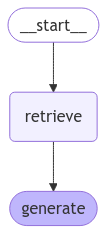

In [66]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# ⚠️Consider it here the end of the lab. THE FOLLOWING IS NOT WORKING ⚠️

Return documents based on similarity to an embedded query.

In [57]:
embedding = embeddings.embed_query("How many chapters in this book ?")

results = vector_store.similarity_search_by_vector(embedding)
print(results[0])

INFO: HTTP Request: POST https://ai-services-52857-400001.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"


NotImplementedError: 

## Layout analysis and extraction of text from images

If you require a more granular segmentation of text (e.g., into distinct paragraphs, titles, tables, or other structures) or require extraction of text from images, the method below is appropriate. It will return a list of Document objects, where each object represents a structure on the page. The Document's metadata stores the page number and other information related to the object (e.g., it might store table rows and columns in the case of a table object).

Under the hood it uses the langchain-unstructured library. See the integration docs for more information about using Unstructured with LangChain.

Unstructured supports multiple parameters for PDF parsing:

* strategy (e.g., "fast" or "hi-res")
* API or local processing. You will need an API key to use the API.

The hi-res strategy provides support for document layout analysis and OCR. We demonstrate it below via the API. See local parsing section below for considerations when running locally.

In [ ]:
%pip install -qU langchain-unstructured

In [ ]:
%pip install "langchain-unstructured[local]"

In [ ]:
# test unstructured
# %pip install unstructured
# %pip install "unstructured[pdf]"
# Install package, compatible with API partitioning
# %pip install --upgrade --quiet langchain-unstructured unstructured-client unstructured "unstructured[pdf]" python-magic
# %pip install onnx
# %pip install libmagic poppler libreoffice pandoc tesseract
# %pip install "unstructured[all-docs]" 
%pip install libmagic-dev poppler-utils tesseract-ocr libreoffice pandoc

In [ ]:
from unstructured.partition.auto import partition

elements = partition(filename="./example_data/azure-for-architects.pdf")
print("\n\n".join([str(el) for el in elements]))

In [ ]:
from langchain_unstructured import UnstructuredLoader

file_paths = [
    "./example_data/azure-for-architects.pdf",
    # "./example_data/state_of_the_union.txt",
]


loader = UnstructuredLoader(file_paths)

In [ ]:
docs = loader.load()

docs[0]

In [ ]:
from unstructured.partition.auto import partition

elements = partition(filename="./example_data/azure-for-architects.pdf")

print("\n\n".join([str(el) for el in elements]))